In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pandas as pd

import astropy.units as u
from astropy.io import fits
from astropy.wcs import WCS
from astropy.wcs.utils import pixel_to_skycoord,skycoord_to_pixel
from astropy.coordinates import SkyCoord
from astropy.nddata import Cutout2D
from tqdm.auto import tqdm

from photutils.detection import DAOStarFinder,IRAFStarFinder
from skimage.registration import phase_cross_correlation
from scipy.ndimage import shift as ndimage_shift
from scipy.optimize import minimize

from warnings import catch_warnings

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from sphot.plotting import astroplot
from util.wcs_correction import (generate_cutout, identify_matching_sources, 
                                 apply_sigma_clip, update_wcs,plot_offset)
from conf import (output_folder, filters, fwhm_dict,
                  filter_ref,galaxy_name, target_pixscale,
                  Ncutouts, Nsources_per_cutout)

# Load data

In [4]:
original_files = {filt: output_folder+f'{filt}_wcscorr.fits' for filt in filters}
headers_to_use = {filt: 'PRIMARY' for filt in filters}
images = [fits.open(output_folder+f'{filt}.fits')[0].data for filt in filters]
images_dict = {filt:img for filt,img in zip(filters,images)}
wcs = WCS(fits.open(output_folder+'F090W.fits')[0].header)
filternames = filters

# Do analysis

In [5]:
# create catalogs
center_coord = SkyCoord.from_name(galaxy_name)
filter_tgt_list = filternames.copy()
filter_tgt_list.remove(filter_ref)
sky_ref_cats = dict(zip(filternames,[[] for filt in filternames]))
sky_tgt_cats = dict(zip(filternames,[[] for filt in filternames]))

for i in tqdm(range(Ncutouts)):
    # generate cutout
    cutouts = generate_cutout(images,filternames,wcs,
                            center_coord = center_coord,
                            cutout_size = (256,256), # pixels
                            offset_min = 0.3, # arcsec
                            offset_max = 3.0, # arcsec
                            plot = False
                            )
    if cutouts is None:
        continue
    
    for filter_tgt in filter_tgt_list:
        # filter-dependent FWHM values
        fwhms = [fwhm_dict[filter_ref],fwhm_dict[filter_tgt]]
        cutout_ref = cutouts[filternames.index(filter_ref)]
        cutout_tgt = cutouts[filternames.index(filter_tgt)]

        # create matched catalog within cutout
        try:
            with catch_warnings(action='ignore'):
                sky_ref,sky_tgt = identify_matching_sources(
                    cutout_ref.data,cutout_tgt.data,
                    filter_ref,filter_tgt,fwhms,
                    cutout_ref.wcs,
                    obj_threshold_sigma = 2.5,
                    source_offset_sigma_clip = 2,
                    max_offset_arcsec = 0.05,
                    plot=False
                    )
            # randomly select top 5 sources and append to list
            if len(sky_ref) < Nsources_per_cutout:
                continue # print(f'Not enough sources detected. Skipping...')
            idx = np.random.choice(len(sky_ref),Nsources_per_cutout,replace=False)               
            sky_ref_cats[filter_tgt].append(sky_ref[idx])
            sky_tgt_cats[filter_tgt].append(sky_tgt[idx])
        except Exception:
            continue # print(f'Error in source identification. Skipping...')
        
for filter_tgt in filter_tgt_list:
    sky_ref_cats[filter_tgt] = SkyCoord(np.concatenate(sky_ref_cats[filter_tgt]))
    sky_tgt_cats[filter_tgt] = SkyCoord(np.concatenate(sky_tgt_cats[filter_tgt]))
    print(f'Sources cross-matched between {filter_tgt} and {filter_ref}: {len(sky_ref_cats[filter_tgt])}')

  0%|          | 0/100 [00:00<?, ?it/s]

Sources cross-matched between F555W and F090W: 305
Sources cross-matched between F814W and F090W: 350
Sources cross-matched between F150W and F090W: 415
Sources cross-matched between F160W and F090W: 160
Sources cross-matched between F277W and F090W: 315


F555W: 305 sources


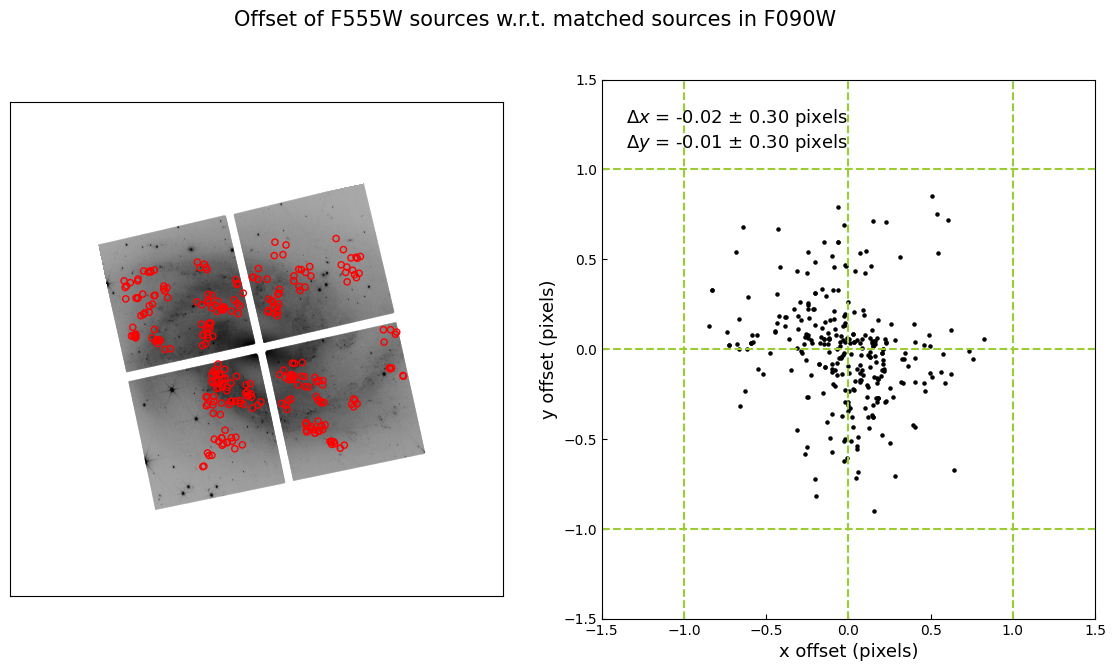

shift_x   :   0.0163 +/- 0.0588 pix
shift_y   :   0.0216 +/- 0.0592 pix
rotation  :   0.0032 +/- 0.0024 deg
F814W: 350 sources


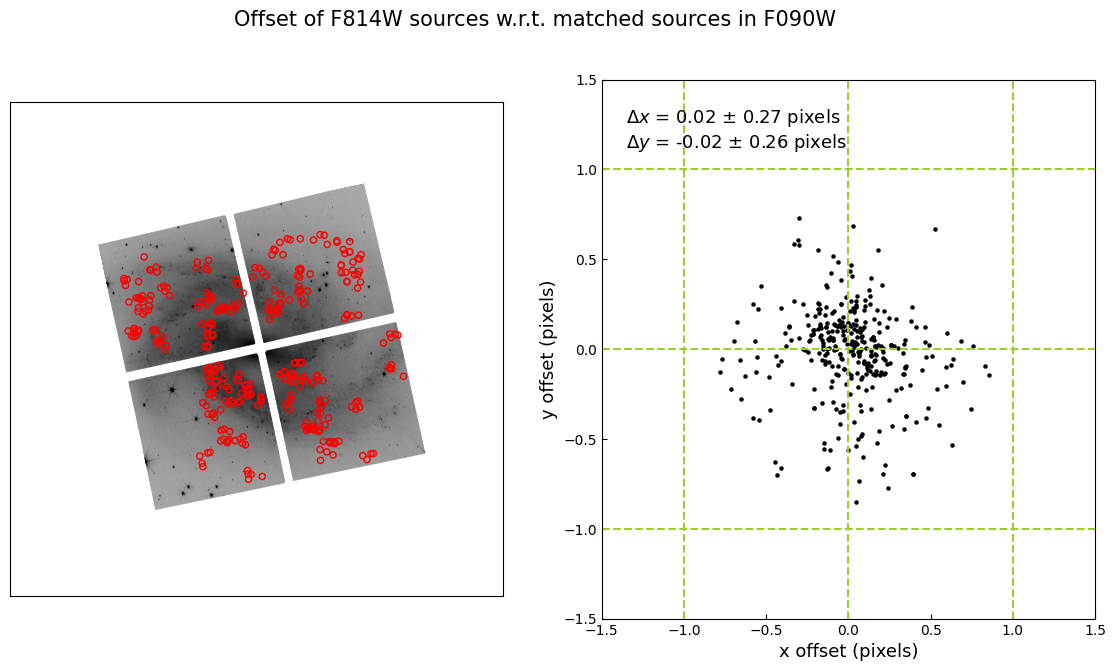

shift_x   :  -0.0182 +/- 0.0543 pix
shift_y   :   0.0214 +/- 0.0542 pix
rotation  :   0.0028 +/- 0.0021 deg
F150W: 415 sources


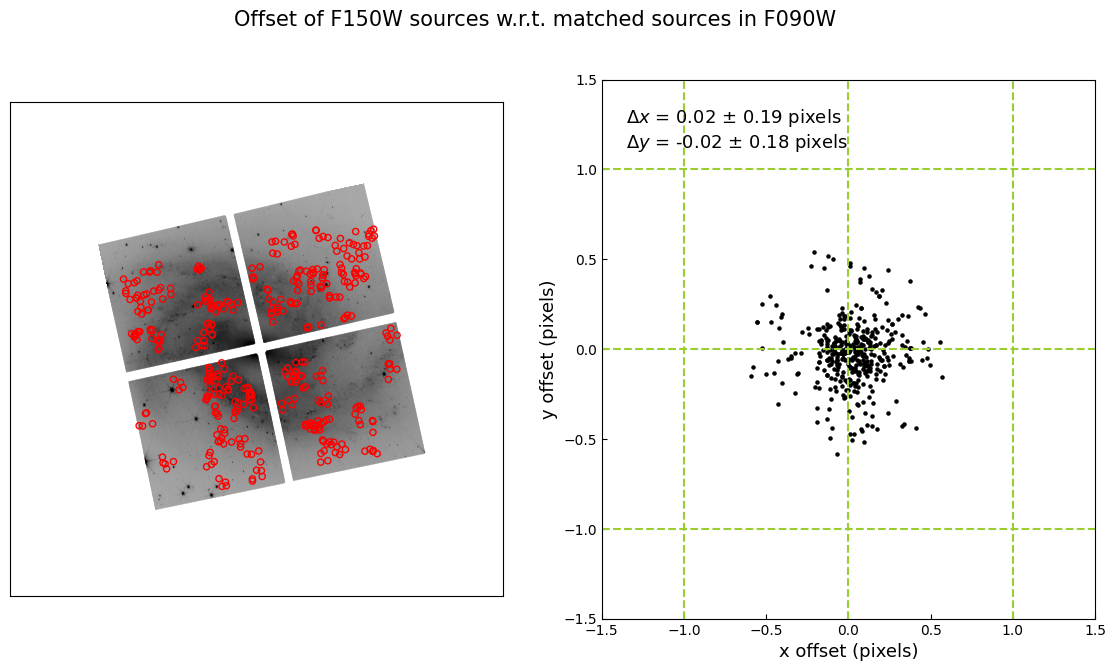

shift_x   :  -0.0306 +/- 0.1008 pix
shift_y   :   0.0201 +/- 0.0538 pix
rotation  :  -0.0002 +/- 0.0018 deg
F160W: 160 sources


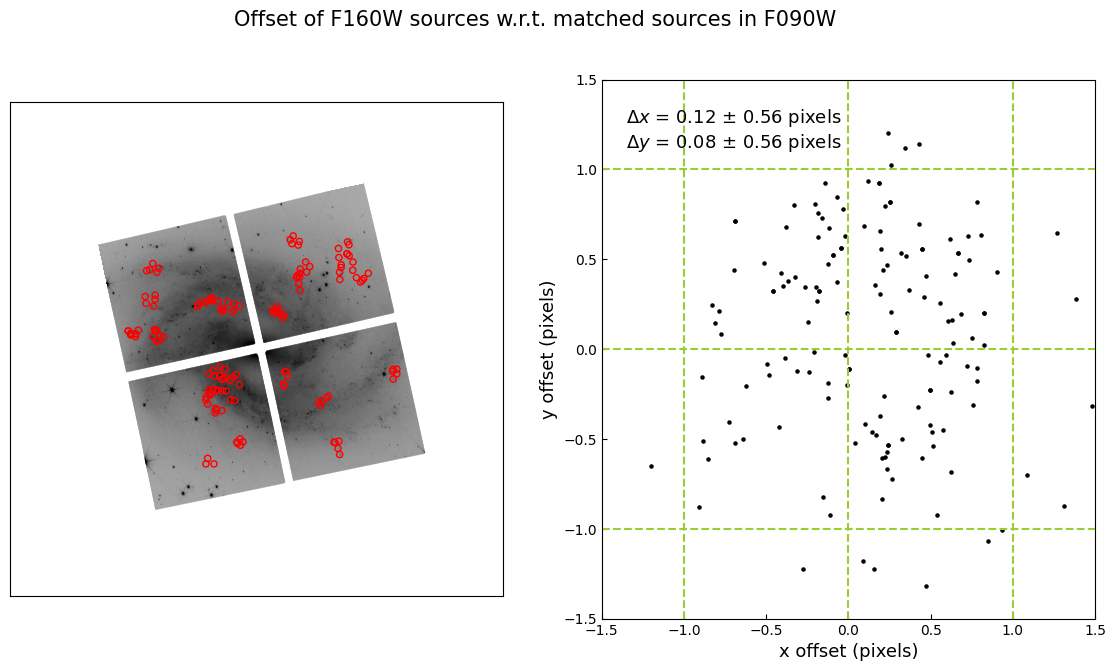

shift_x   :  -0.0467 +/- 0.0810 pix
shift_y   :   0.0453 +/- 0.0821 pix
rotation  :   0.0227 +/- 0.0031 deg
F277W: 315 sources


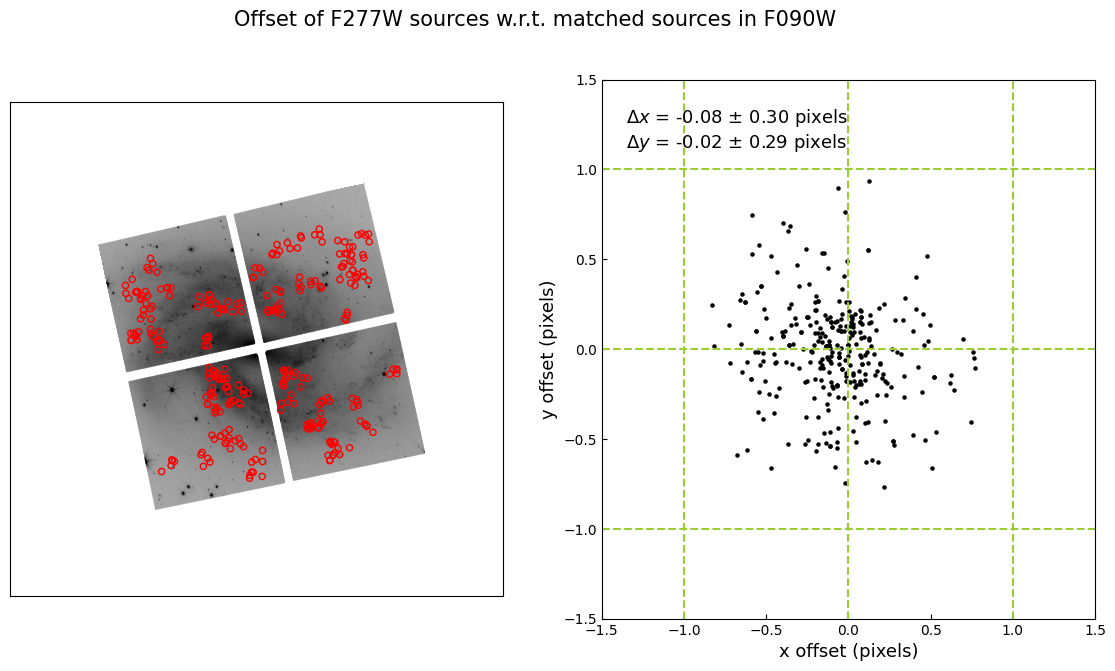

shift_x   :   0.0890 +/- 0.1123 pix
shift_y   :   0.0202 +/- 0.0617 pix
rotation  :   0.0002 +/- 0.0020 deg


In [8]:
from warnings import filterwarnings
filterwarnings('ignore')
updated_WCSs = {}
for filter_tgt in filter_tgt_list:
    print(f'{filter_tgt}: {len(sky_ref_cats[filter_tgt])} sources')
    
    # convert to pixel coordinates
    ref_x,ref_y = skycoord_to_pixel(sky_ref_cats[filter_tgt],wcs)
    tgt_x,tgt_y = skycoord_to_pixel(sky_tgt_cats[filter_tgt],wcs)

    _,mask = apply_sigma_clip(np.sqrt((tgt_x - ref_x)**2 + (tgt_y - ref_y)**2),3)
    ref_x, ref_y = ref_x[mask], ref_y[mask]
    tgt_x, tgt_y = tgt_x[mask], tgt_y[mask]
    plot_offset(images_dict['F090W'],ref_x,ref_y,tgt_x,tgt_y,filter_ref,filter_tgt)
    plt.show()
    
    original_file = original_files[filter_tgt]
    header_to_use = headers_to_use[filter_tgt]
    wcs_updated = update_wcs(original_file,header_to_use,ref_x,ref_y,tgt_x,tgt_y,wcs,target_pixscale)
    updated_WCSs[filter_tgt] = wcs_updated

## apply correction

In [9]:
for filter_tgt in filter_tgt_list:
    original_file = original_files[filter_tgt]
    header_to_use = headers_to_use[filter_tgt]
    wcs_updated = updated_WCSs[filter_tgt]
    
    # save data
    hdu = fits.open(original_file)[header_to_use]
    outfile = output_folder+f'{filter_tgt}_wcscorr.fits'
    updated_header = hdu.header.copy()
    updated_header.update(wcs_updated.to_header())
    fits.writeto(outfile, 
                data=hdu.data, 
                header=updated_header,
                overwrite=True)
    print('saved to',outfile)

saved to /Volumes/S-Express/SH0ES_reprojected/N2525/F555W_wcscorr.fits
saved to /Volumes/S-Express/SH0ES_reprojected/N2525/F814W_wcscorr.fits
saved to /Volumes/S-Express/SH0ES_reprojected/N2525/F150W_wcscorr.fits
saved to /Volumes/S-Express/SH0ES_reprojected/N2525/F160W_wcscorr.fits
saved to /Volumes/S-Express/SH0ES_reprojected/N2525/F277W_wcscorr.fits
